In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression



import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_age(x):
    cat = ''
    if x == "19세 이하" or x == "20세~24세": cat = "학생층"
    elif x == "25세~29세" or x == "30세~34세": cat = "청년층"
    elif x == "35세~39세" or x == "40세~44세": cat = "중년층"
    elif x == "45세~49세" or x == "50세~54세": cat = "장년층"
    else : cat = "노년층"
    
    return cat

def get_region(x):
    cat = ''
    if x == "110": cat = "경기"
    elif x == "210": cat = "인천"
    elif x == "240": cat = "강원"
    elif x == "270": cat = "충북"
    elif x == "300": cat = "세종"
    elif x == "310": cat = "충남"
    elif x == "340": cat = "대전"
    elif x == "360": cat = "경북"
    elif x == "410": cat = "대구"
    elif x == "440": cat = "울산"
    elif x == "460": cat = "부산"
    elif x == "500": cat = "경남"
    elif x == "540": cat = "전북"
    elif x == "570": cat = "전남"
    elif x == "610": cat = "광주"
    elif x == "630": cat = "제주"
    else : cat = "서울"
    
    return cat

In [3]:
db = cx_Oracle.connect("c##lm", "lm", "localhost:1521/xe")
cursor = db.cursor()
cursor.execute("select * from PREDICTDATA")
x = cursor.fetchall()

predictdata = pd.DataFrame(x)

cursor.execute("select column_name from user_tab_columns where table_name = 'PREDICTDATA'")
col = cursor.fetchall()
list1 = []
for i in col:
    for j in i:
        list1.append(j)
        
predictdata.columns = list1

In [4]:
predictdata.drop(["가공Q14_1","가공Q14_2","가공Q14_3","가공Q14_4","가공Q15_1","가공Q15_2","가공Q15_3",'가공Q15_4','신선Q14_1'
,'신선Q14_2','신선Q14_3','신선Q14_4','신선Q15_1','신선Q15_2','신선Q15_3','신선Q15_4','일상Q14_1','일상Q14_2','일상Q14_3'
,'일상Q14_4','일상Q15_1','일상Q15_2','일상Q15_3','일상Q15_4','의약Q14_1','의약Q14_2','의약Q14_3','의약Q14_4','의약Q15_1'
,'의약Q15_2','의약Q15_3','의약Q15_4','교육Q14_1','교육Q14_2','교육Q14_3','교육Q14_4','교육Q15_1','교육Q15_2','교육Q15_3'
,'교육Q15_4','디지털Q14_1','디지털Q14_2','디지털Q14_3','디지털Q14_4','디지털Q15_1','디지털Q15_2','디지털Q15_3','디지털Q15_4'
,'가구Q14_1','가구Q14_2','가구Q14_3','가구Q14_4','가구Q15_1','가구Q15_2','가구Q15_3','가구Q15_4','의류Q14_1','의류Q14_2'
,'의류Q14_3','의류Q14_4','의류Q15_1','의류Q15_2','의류Q15_3','의류Q15_4','전문스포츠Q14_1','전문스포츠Q14_2','전문스포츠Q14_3'
,'전문스포츠Q14_4','전문스포츠Q15_1','전문스포츠Q15_2','전문스포츠Q15_3','전문스포츠Q15_4','패션잡화Q14_1','패션잡화Q14_2'
,'패션잡화Q14_3','패션잡화Q14_4','패션잡화Q15_1','패션잡화Q15_2','패션잡화Q15_3','패션잡화Q15_4','명품Q14_1','명품Q14_2'
,'명품Q14_3','명품Q14_4','명품Q15_1','명품Q15_2','명품Q15_3','명품Q15_4','기타Q14_1','기타Q14_2','기타Q14_3','기타Q14_4'
,'기타Q15_1','기타Q15_2','기타Q15_3','기타Q15_4'], axis = 1, inplace = True)

In [5]:
predictdata.drop(["A선호점포","B선호점포","C선호점포","D선호점포","선호제휴사","선호점포", '14_2분기변화', '14_3분기변화', '14_4분기변화',
       '15_1분기변화', '15_2분기변화', '15_3분기변화'], axis = 1, inplace = True)

In [6]:
pf = pd.read_excel("dataSet/productfeatures.xlsx")
pf['고객번호'] = pf['고객번호'].astype(str)
pf['고객번호'] = pf['고객번호'].str.zfill(5)
pf

,고객번호,가공train변화율,가공train순증감률,가공test변화율,가공test순증감률,신선train변화율,신선train순증감률,신선test변화율,신선test순증감률,일상train변화율,...,패션test변화율,패션test순증감률,명품train변화율,명품train순증감률,명품test변화율,명품test순증감률,기타train변화율,기타train순증감률,기타test변화율,기타test순증감률
0,00001,3,-3,5,-5,14,2,18,-6,11,...,19,-7,4,0,5,0,4,0,4,1
1,00002,9,-9,13,-4,1,0,1,-1,0,...,7,-2,5,-1,5,0,11,-7,17,1
2,00003,4,0,5,-2,5,-1,6,0,2,...,0,0,1,-1,1,0,4,-2,4,-2
3,00004,13,1,15,-3,12,2,13,-2,14,...,11,-4,1,-1,2,1,23,-3,29,-1
4,00005,14,-2,21,-9,9,-4,10,-6,25,...,5,-4,1,-1,1,-1,7,-3,7,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,19379,0,0,0,0,0,0,0,0,8,...,15,0,1,-1,1,0,7,1,11,-2
19379,19380,0,0,0,0,0,0,1,1,9,...,4,2,1,-1,1,0,3,-3,3,-2
19380,19381,5,5,7,7,9,5,10,8,1,...,5,1,1,-1,1,0,6,0,7,0
19381,19382,4,4,6,6,5,3,5,5,2,...,5,0,1,-1,1,0,3,-3,4,-1


In [7]:
mf = pd.read_excel("dataSet/meanfeatures.xlsx")
mf['고객번호'] = mf['고객번호'].astype(str)
mf['고객번호'] = mf['고객번호'].str.zfill(5)
mf

,고객번호,가공평균train,가공평균test,신선평균train,신선평균test,일상평균train,일상평균test,의약평균train,의약평균test,교육평균train,...,의류평균train,의류평균test,스포츠평균train,스포츠평균test,패션평균train,패션평균test,명품평균train,명품평균test,기타평균train,기타평균test
0,00001,2,2,3,3,2,4,3,3,2,...,1,1,3,3,2,2,2,2,1,1
1,00002,4,5,1,1,1,1,3,3,2,...,1,1,1,1,2,1,2,2,4,4
2,00003,8,9,8,8,9,9,3,4,2,...,8,8,5,5,8,8,2,3,6,6
3,00004,6,6,6,6,5,6,3,3,2,...,4,3,3,3,4,4,2,2,4,4
4,00005,3,4,6,7,5,7,3,4,2,...,6,6,5,5,6,6,2,2,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,19379,10,10,10,10,5,4,3,3,2,...,7,7,5,5,6,5,2,3,5,6
19379,19380,10,10,10,9,7,6,3,3,2,...,8,9,5,5,7,7,2,3,6,7
19380,19381,9,7,7,6,9,9,3,3,2,...,7,7,5,5,7,7,2,3,6,6
19381,19382,8,7,8,7,9,9,3,2,2,...,8,8,5,5,7,7,2,3,6,7


In [8]:
predictdata = pd.merge(predictdata, pf, on='고객번호')
predictdata = pd.merge(predictdata, mf, on='고객번호')

In [9]:
pd.set_option("display.max_columns", None)
predictdata.sort_values("고객번호")

,고객번호,성별,연령대,거주지역,14_1분기,14_2분기,14_3분기,14_4분기,15_1분기,15_2분기,15_3분기,선호제휴점포,최근성,행동 빈도,구매 총액,15_4분기,최근성train,최근성test,행동 빈도train,행동 빈도test,구매 총액train,구매 총액test,F14_1,F14_2,F14_3,F14_4,F15_1,F15_2,F15_3,F15_4,가공train변화율,가공train순증감률,가공test변화율,가공test순증감률,신선train변화율,신선train순증감률,신선test변화율,신선test순증감률,일상train변화율,일상train순증감률,일상test변화율,일상test순증감률,의약train변화율,의약train순증감률,의약test변화율,의약test순증감률,교육train변화율,교육train순증감률,교육test변화율,교육test순증감률,디지털train변화율,디지털train순증감률,디지털test변화율,디지털test순증감률,가구train변화율,가구train순증감률,가구test변화율,가구test순증감률,의류train변화율,의류train순증감률,의류test변화율,의류test순증감률,전문스포츠train변화율,전문스포츠train순증감률,전문스포츠test변화율,전문스포츠test순증감률,패션train변화율,패션train순증감률,패션test변화율,패션test순증감률,명품train변화율,명품train순증감률,명품test변화율,명품test순증감률,기타train변화율,기타train순증감률,기타test변화율,기타test순증감률,가공평균train,가공평균test,신선평균train,신선평균test,일상평균train,일상평균test,의약평균train,의약평균test,교육평균train,교육평균test,디지털평균train,디지털평균test,가구평균train,가구평균test,의류평균train,의류평균test,스포츠평균train,스포츠평균test,패션평균train,패션평균test,명품평균train,명품평균test,기타평균train,기타평균test
18,00001,M,60세이상,060,9141590.0,10783765.0,10781550.0,23334762.0,9302985.0,8595380.0,7806580.0,A12,9.0,979.0,79746612.0,5295938.0,4.0,9.0,906.0,979.0,71940032.0,79746612.0,121.0,117.0,142.0,214.0,172.0,140.0,73.0,78.0,3,-3,5,-5,14,2,18,-6,11,-7,13,-7,3,-1,3,0,0,0,0,0,4,0,6,2,8,0,11,0,0,0,0,0,11,-3,12,-2,12,-6,19,-7,4,0,5,0,4,0,4,1,2,2,3,3,2,4,3,3,2,2,2,2,1,2,1,1,3,3,2,2,2,2,1,1
19,00002,M,60세이상,100,14123470.0,10199760.0,14841180.0,7080920.0,18481480.0,9310130.0,13842600.0,A7,2.0,997.0,87879540.0,12001220.0,7.0,2.0,871.0,997.0,74036940.0,87879540.0,184.0,155.0,139.0,132.0,145.0,116.0,126.0,119.0,9,-9,13,-4,1,0,1,-1,0,0,0,0,4,2,7,0,0,0,0,0,6,-2,8,0,7,-3,10,2,4,0,5,1,3,-1,4,0,5,-1,7,-2,5,-1,5,0,11,-7,17,1,4,5,1,1,1,1,3,3,2,2,1,1,2,2,1,1,1,1,2,1,2,2,4,4
20,00003,M,60세이상,033,302782.0,548433.0,648188.0,394366.0,279310.0,312970.0,421017.0,C34,9.0,1098.0,2907066.0,258101.0,2.0,9.0,959.0,1098.0,2486049.0,2907066.0,139.0,209.0,246.0,145.0,87.0,133.0,139.0,93.0,4,0,5,-2,5,-1,6,0,2,0,3,1,1,-1,1,0,0,0,0,0,2,0,2,0,2,0,2,0,3,-1,3,-2,3,-1,3,0,0,0,0,0,1,-1,1,0,4,-2,4,-2,8,9,8,8,9,9,3,4,2,2,2,2,4,4,8,8,5,5,8,8,2,3,6,6
21,00004,F,60세이상,016,1309643.0,3732463.0,2434410.0,1823100.0,1737292.0,1919645.0,2127112.0,A20,1.0,823.0,15083665.0,1610145.0,1.0,1.0,705.0,823.0,12956553.0,15083665.0,93.0,177.0,85.0,87.0,122.0,141.0,118.0,107.0,13,1,15,-3,12,2,13,-2,14,2,17,1,3,-1,3,0,0,0,0,0,0,0,0,0,6,0,8,2,4,2,5,0,4,-2,6,0,11,-3,11,-4,1,-1,2,1,23,-3,29,-1,6,6,6,6,5,6,3,3,2,2,3,3,3,2,4,3,3,3,4,4,2,2,4,4
22,00005,M,60세이상,100,3145330.0,2314820.0,1827290.0,398440.0,2124430.0,810500.0,NaN,A7,133.0,630.0,10620810.0,2616260.0,41.0,133.0,630.0,630.0,10620810.0,10620810.0,184.0,193.0,110.0,20.0,93.0,30.0,NaN,89.0,14,-2,21,-9,9,-4,10,-6,25,-9,25,-4,1,-1,1,0,0,0,0,0,2,0,2,-1,8,0,8,0,15,-3,15,-4,8,-2,8,0,5,-3,5,-4,1,-1,1,-1,7,-3,7,-5,3,4,6,7,5,7,3,4,2,2,2,2,3,3,6,6,5,5,6,6,2,2,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19103,19379,F,20세~24세,069,NaN,NaN,130300.0,1060320.0,1131020.0,1264900.0,805550.0,D15,2.0,470.0,4392090.0,1387190.0,1.0,2.0,349.0,470.0,3586540.0,4392090.0,NaN,NaN,11.0,76.0,125.0,137.0,121.0,114.0,0,0,0,0,0,0,0,0,8,8,8,8,3,1,5,0,0,0,0,0,2,0,2,0,2,0,2,0,5,3,8,1,3,-1,3,0,12,0,15,0,1,-1,1,0,7,1,11,-2,10,10,10,10,5,4,3,3,2,2,2,2,4,4,7,7,5,5,6,5,2,3,5,6
19104,19380,F,20세~24세,039,NaN,NaN,NaN,522700.0,486830.0,351120.0,368907.0,D1,2.0,172.0,1729557.0,2183420.0,1.0,2.0,120.0,172.0,1360650.0,1729557.0,NaN,NaN,NaN,17.0,62.0,41.0,52.0,268.0,0,0,0,0,0,0,1,1,9,5,9,5,3,1,5,0,0,0,0,0,2,0,2,0,2,0,2,0,1,-1,1,0,3,-1,3,0,2,2,4,2,1,-1,1,0,3,-3,3,-2,10,10,10,9,7,6,3,3,2,2,2,2,4,4,8,9,5,5,7,7,2,3,6,7
19125,19381,F,40세~44세,460,NaN,NaN,NaN,NaN,1124750.0,

In [10]:
predictdata.rename(columns = {"F15_2" : "Rtrain", "F14_1" : "Rtest",
                   "행동 빈도train" : "Ftrain", "구매 총액test" : "Ftest",
                   "F15_3" : "Mtrain", "F15_1" : "Mtest", "F14_3" : "14_1F",
                    "최근성test" : "14_2F", "구매 총액train" : "14_3F", "행동 빈도test" : "14_4F",
                    "F14_4" : "15_1F", "최근성train" : "15_2F", "F15_4" : "15_3F", "F14_2" : "15_4F"}, inplace = True)

In [11]:
predictdata = predictdata.dropna(subset=['14_1분기', '14_2분기', '14_3분기', '14_4분기',
       '15_1분기', '15_2분기', '15_3분기', '15_4분기'])

In [12]:
predictdata["14_1분기"] = round(predictdata["14_1분기"] * 1.0109552634860561)
predictdata["14_2분기"] = round(predictdata["14_2분기"] * 1.005856410415038)
predictdata["14_3분기"] = round(predictdata["14_3분기"] * 1.0238994118951612)
predictdata["14_4분기"] = round(predictdata["14_4분기"] * 0.9669899689775655)
predictdata["15_1분기"] = round(predictdata["15_1분기"] * 1.0109552634859216)
predictdata["15_2분기"] = round(predictdata["15_2분기"] * 1.005856410415038)
predictdata["15_3분기"] = round(predictdata["15_3분기"] * 1.0238994118951612)
predictdata["15_4분기"] = round(predictdata["15_4분기"] * 0.9669899689775655)

In [13]:
predictdata

,고객번호,성별,연령대,거주지역,14_1분기,14_2분기,14_3분기,14_4분기,15_1분기,15_2분기,15_3분기,선호제휴점포,최근성,행동 빈도,구매 총액,15_4분기,15_2F,14_2F,Ftrain,14_4F,14_3F,Ftest,Rtest,15_4F,14_1F,15_1F,Mtest,Rtrain,Mtrain,15_3F,가공train변화율,가공train순증감률,가공test변화율,가공test순증감률,신선train변화율,신선train순증감률,신선test변화율,신선test순증감률,일상train변화율,일상train순증감률,일상test변화율,일상test순증감률,의약train변화율,의약train순증감률,의약test변화율,의약test순증감률,교육train변화율,교육train순증감률,교육test변화율,교육test순증감률,디지털train변화율,디지털train순증감률,디지털test변화율,디지털test순증감률,가구train변화율,가구train순증감률,가구test변화율,가구test순증감률,의류train변화율,의류train순증감률,의류test변화율,의류test순증감률,전문스포츠train변화율,전문스포츠train순증감률,전문스포츠test변화율,전문스포츠test순증감률,패션train변화율,패션train순증감률,패션test변화율,패션test순증감률,명품train변화율,명품train순증감률,명품test변화율,명품test순증감률,기타train변화율,기타train순증감률,기타test변화율,기타test순증감률,가공평균train,가공평균test,신선평균train,신선평균test,일상평균train,일상평균test,의약평균train,의약평균test,교육평균train,교육평균test,디지털평균train,디지털평균test,가구평균train,가구평균test,의류평균train,의류평균test,스포츠평균train,스포츠평균test,패션평균train,패션평균test,명품평균train,명품평균test,기타평균train,기타평균test
0,00077,F,60세이상,460,4206241.0,5238049.0,4110362.0,4155548.0,3875982.0,4083513.0,3468666.0,A29,1.0,939.0,28961456.0,7142362.0,5.0,1.0,808.0,939.0,25573754.0,28961456.0,99.0,111.0,198.0,141.0,107.0,152.0,131.0,153.0,10,2,11,1,1,-1,1,-1,9,-1,9,-1,1,-1,1,0,3,-1,3,0,0,0,0,0,7,1,8,0,7,1,8,-1,3,-1,5,1,11,-3,11,2,3,-1,4,-1,15,1,18,5,5,4,1,1,2,2,3,4,1,1,3,3,3,3,2,2,5,5,3,4,2,2,4,4
1,00078,F,60세이상,100,9766885.0,6514676.0,9668621.0,9744667.0,11963968.0,21988555.0,11833083.0,A2,6.0,900.0,80909783.0,11077953.0,2.0,6.0,762.0,900.0,69352903.0,80909783.0,111.0,70.0,129.0,126.0,153.0,173.0,138.0,129.0,13,1,16,4,7,1,7,4,16,0,16,7,3,-3,3,0,0,0,0,0,5,1,6,2,4,0,5,0,7,3,7,1,4,0,4,2,0,0,3,0,1,-1,2,0,15,1,18,5,2,2,2,2,4,4,3,4,2,2,2,2,1,2,2,1,1,1,1,1,1,1,5,4
2,00079,F,60세이상,055,1950308.0,1938225.0,2304859.0,2222886.0,1398972.0,2236843.0,2409446.0,B7,2.0,1843.0,14366778.0,1510031.0,1.0,2.0,1531.0,1843.0,12013572.0,14366778.0,270.0,193.0,273.0,273.0,210.0,312.0,312.0,189.0,7,1,7,2,9,-3,9,2,14,2,18,-2,1,-1,1,0,2,0,2,-1,0,0,0,0,2,0,2,0,5,-3,9,1,5,1,7,-2,8,-2,10,-2,1,-1,1,0,9,-1,9,-4,2,2,2,2,5,6,3,4,1,1,3,3,4,4,6,6,4,4,5,5,2,3,4,4
3,00080,F,60세이상,055,1029527.0,808245.0,1213195.0,1449969.0,1288179.0,1715306.0,1161362.0,C195,1.0,1466.0,8620045.0,2188477.0,2.0,1.0,1245.0,1466.0,7485791.0,8620045.0,243.0,129.0,227.0,248.0,177.0,221.0,221.0,209.0,9,-3,11,3,10,-1,10,3,15,-1,16,-4,1,-1,1,0,0,0,0,0,0,0,0,0,3,-1,3,-1,5,1,7,0,3,-1,3,0,4,0,5,0,1,-1,1,0,20,4,27,-2,7,7,3,3,6,6,3,4,2,2,3,3,3,4,7,7,5,5,7,7,2,3,4,4
4,00081,F,60세이상,016,9753979.0,5376946.0,8774685.0,5342521.0,7315394.0,12382062.0,17024376.0,A20,1.0,708.0,65261778.0,8763927.0,1.0,1.0,587.0,708.0,48634778.0,65261778.0,89.0,99.0,75.0,77.0,130.0,117.0,121.0,87.0,8,2,10,3,16,3,17,-4,5,1,5,0,1,-1,1,0,0,0,0,0,8,0,9,1,8,0,10,-2,6,0,7,1,7,-1,8,1,10,2,12,-1,2,0,2,1,17,-5,17,-4,6,5,5,5,1,1,3,4,2,2,2,2,2,2,2,2,5,5,3,3,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,16756,F,40세~44세,210,1415895.0,1823472.0,2057036.0,1211928.0,1878708.0,1675968.0,1929245.0,B38,1.0,1502.0,11884500.0,2474748.0,1.0,1.0,1288.0,1502.0,10000287.0,11884500.0,147.0,233.0,212.0,182.0,263.0,251.0,214.0,200.0,5,1,5,-1,4,2,6,-2,6,0,6,0,4,2,5,1,0,0,0,0,0,0,0,0,7,1,7,0,3,-3,4,-1,2,0,3,-1,7,1,8,1,3,-1,3,0,5,3,6,1,8,8,5,5,4,4,3,3,2,2,3,3,2,2,5,5,5,5,5,5,2,2,2,2
19379,16527,F,35세~39세,100,488676.0,672135.0,764505.0,690518.0,958424.0,1158113.0,1424408.0,C491,1.0,1877.0,6102920.0,1490331.0,1.0,1.0,1466.0,1877.0,4711760.0,6102920.0,162.0,209.0,214.0,237.0,293.0,351.0,411.0,348.0,7,5,8,3,4,1,5,1,1,1,1,1,1,-1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,-1,3,2,3,-1,3,0,0,0,3,0,1,-1,1,0,5,-3,6,-1,5,4,7,7,9,9,3,4,2,1,3,3,4,4,8,8,5,5,8,7,2,3,6,6
19380,17503,F,55세~59세

In [14]:
predictdata['14_1순위'] = predictdata['14_1분기'].rank(method='min')
predictdata['14_2순위'] = predictdata['14_2분기'].rank(method='min')
predictdata['14_3순위'] = predictdata['14_3분기'].rank(method='min')
predictdata['14_4순위'] = predictdata['14_4분기'].rank(method='min')
predictdata['15_1순위'] = predictdata['15_1분기'].rank(method='min')
predictdata['15_2순위'] = predictdata['15_2분기'].rank(method='min')
predictdata['15_3순위'] = predictdata['15_3분기'].rank(method='min')
predictdata['15_4순위'] = predictdata['15_4분기'].rank(method='min')

In [15]:
def get_rank(x):
    cat = ''
    if x < 1886 : cat = 1
    elif x < 3773 : cat = 2
    elif x < 5659 : cat = 3
    elif x < 7546 : cat = 4
    elif x < 9433 : cat = 5
    elif x < 11319 : cat = 6
    elif x < 13206 : cat = 7
    elif x < 15092 : cat = 8
    elif x < 16979 : cat = 9   
    else: cat = 10
        
    
    return cat

In [16]:
predictdata["14_1랭크"] = predictdata["14_1순위"].apply(lambda x : get_rank(x))
predictdata["14_2랭크"] = predictdata["14_2순위"].apply(lambda x : get_rank(x))
predictdata["14_3랭크"] = predictdata["14_3순위"].apply(lambda x : get_rank(x))
predictdata["14_4랭크"] = predictdata["14_4순위"].apply(lambda x : get_rank(x))
predictdata["15_1랭크"] = predictdata["15_1순위"].apply(lambda x : get_rank(x))
predictdata["15_2랭크"] = predictdata["15_2순위"].apply(lambda x : get_rank(x))
predictdata["15_3랭크"] = predictdata["15_3순위"].apply(lambda x : get_rank(x))
predictdata["15_4랭크"] = predictdata["15_4순위"].apply(lambda x : get_rank(x))

In [17]:
predictdata["종합변화율train"] = (
    abs(predictdata["14_2랭크"]-predictdata["14_1랭크"])+
    abs(predictdata["14_3랭크"]-predictdata["14_2랭크"])+
    abs(predictdata["14_4랭크"]-predictdata["14_3랭크"])+
    abs(predictdata["15_1랭크"]-predictdata["14_4랭크"])+
    abs(predictdata["15_2랭크"]-predictdata["15_1랭크"])
)

predictdata["종합변화율test"] = (
    abs(predictdata["14_3랭크"]-predictdata["14_2랭크"])+
    abs(predictdata["14_4랭크"]-predictdata["14_3랭크"])+
    abs(predictdata["15_1랭크"]-predictdata["14_4랭크"])+
    abs(predictdata["15_2랭크"]-predictdata["15_1랭크"])+
    abs(predictdata["15_3랭크"]-predictdata["15_2랭크"])
)

In [18]:
predictdata["종합순증감률train"] = predictdata["15_2랭크"] - predictdata["14_1랭크"]
predictdata["종합순증감률test"] = predictdata["15_3랭크"] - predictdata["14_2랭크"]

In [19]:
predictdata['14_1순위'] = predictdata['14_1분기'].rank(method='min')
predictdata['14_2순위'] = predictdata['14_2분기'].rank(method='min')
predictdata['14_3순위'] = predictdata['14_3분기'].rank(method='min')
predictdata['14_4순위'] = predictdata['14_4분기'].rank(method='min')
predictdata['15_1순위'] = predictdata['15_1분기'].rank(method='min')
predictdata['15_2순위'] = predictdata['15_2분기'].rank(method='min')
predictdata['15_3순위'] = predictdata['15_3분기'].rank(method='min')
predictdata['15_4순위'] = predictdata['15_4분기'].rank(method='min')

In [20]:
predictdata["Rtrain순위"] = predictdata["Rtrain"].rank(method = "min")
predictdata["Rtest순위"] = predictdata["Rtest"].rank(method = "min")
predictdata["Ftrain순위"] = predictdata["Ftrain"].rank(method = "min")
predictdata["Ftest순위"] = predictdata["Ftest"].rank(method = "min")
predictdata["Mtrain순위"] = predictdata["Mtrain"].rank(method = "min")
predictdata["Mtest순위"] = predictdata["Mtest"].rank(method = "min")

In [21]:
predictdata["Rtrain랭크"] = predictdata["Rtrain순위"].apply(lambda x : get_rank(x))
predictdata["Rtest랭크"] = predictdata["Rtest순위"].apply(lambda x : get_rank(x))
predictdata["Ftrain랭크"] = predictdata["Ftrain순위"].apply(lambda x : get_rank(x))
predictdata["Ftest랭크"] = predictdata["Ftest순위"].apply(lambda x : get_rank(x))
predictdata["Mtrain랭크"] = predictdata["Mtrain순위"].apply(lambda x : get_rank(x))
predictdata["Mtest랭크"] = predictdata["Mtest순위"].apply(lambda x : get_rank(x))

In [22]:
predictdata["testLabel"] = round(predictdata["15_4분기"] / predictdata["14_3분기"] * 100,2)
predictdata["trainLabel"] = round(predictdata["15_3분기"] / predictdata["14_2분기"] * 100,2)

In [23]:
predictdata["거주지역"] = predictdata["거주지역"].apply(lambda x : get_region(x))
predictdata["연령대"] = predictdata["연령대"].apply(lambda x : get_age(x))

In [24]:
predictdata["14_2변화율"] = round(predictdata["14_2분기"] / predictdata["14_1분기"] * 100,2)
predictdata["14_3변화율"] = round(predictdata["14_3분기"] / predictdata["14_2분기"] * 100,2)
predictdata["14_4변화율"] = round(predictdata["14_4분기"] / predictdata["14_3분기"] * 100,2)
predictdata["15_1변화율"] = round(predictdata["15_1분기"] / predictdata["14_4분기"] * 100,2)
predictdata["15_2변화율"] = round(predictdata["15_2분기"] / predictdata["15_1분기"] * 100,2)
predictdata["15_3변화율"] = round(predictdata["15_3분기"] / predictdata["15_2분기"] * 100,2)
predictdata["15_4변화율"] = round(predictdata["15_4분기"] / predictdata["15_3분기"] * 100,2)

In [32]:
predictdata["변화율"] = round(predictdata["15_4분기"] / predictdata["14_1분기"] * 100,2)

In [33]:
a = predictdata[(predictdata["변화율"] < 200) & (predictdata["변화율"] > 0)]

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

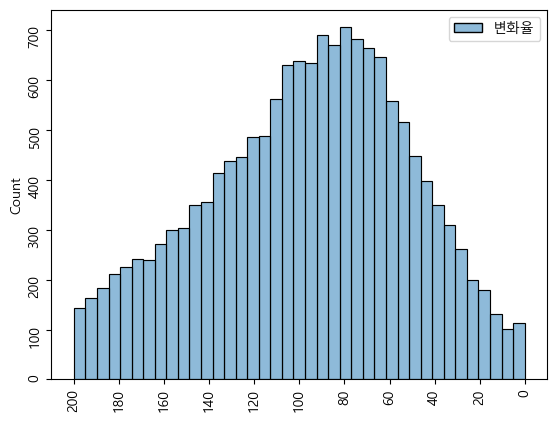

In [49]:
sns.histplot(a[["변화율"]])


plt.xticks(range(0, 201, 20), rotation=90)
plt.gca().invert_xaxis()
plt.yticks(rotation=90)


In [26]:
classtest = predictdata[["성별", "연령대", "거주지역", "선호제휴점포", "14_2F", "14_3F","14_4F","15_1F","15_2F","15_3F"
                         '가공test변화율','가공test순증감률', 
'신선test변화율','신선test순증감률','일상test변화율','일상test순증감률','의약test변화율','의약test순증감률','교육test변화율',
'교육test순증감률','디지털test변화율','디지털test순증감률','가구test변화율','가구test순증감률','의류test변화율',
'의류test순증감률','전문스포츠test변화율','전문스포츠test순증감률','패션test변화율','패션test순증감률','명품test변화율',
'명품test순증감률','기타test변화율','기타test순증감률','종합변화율test','종합순증감률test','Rtest랭크','Ftest랭크','Mtest랭크',
"testLabel"]]

KeyError: "['15_3F가공test변화율'] not in index"

In [ ]:
classtrain = predictdata[["성별", "연령대", "거주지역", "선호제휴점포", "14_1F","14_2F", "14_3F", "14_4F", "15_1F", "15_2F"
                          '가공train변화율','가공train순증감률',
'신선train변화율','신선train순증감률','일상train변화율','일상train순증감률','의약train변화율','의약train순증감률','교육train변화율',
'교육train순증감률','디지털train변화율','디지털train순증감률','가구train변화율','가구train순증감률','의류train변화율',
'의류train순증감률','전문스포츠train변화율','전문스포츠train순증감률','패션train변화율','패션train순증감률','명품train변화율',
'명품train순증감률','기타train변화율','기타train순증감률','종합변화율train','종합순증감률train','Rtrain랭크','Ftrain랭크','Mtrain랭크',
"trainLabel"]]

In [ ]:
#testdata["14_3변화율"] = np.log1p(testdata["14_3변화율"])
#testdata["14_4변화율"] = np.log1p(testdata["14_4변화율"])
#testdata["15_1변화율"] = np.log1p(testdata["15_1변화율"])
#testdata["15_2변화율"] = np.log1p(testdata["15_2변화율"])
#testdata["15_3변화율"] = np.log1p(testdata["15_3변화율"])

In [ ]:
#traindata["14_2변화율"] = np.log1p(traindata["14_2변화율"])
#traindata["14_3변화율"] = np.log1p(traindata["14_3변화율"])
#traindata["14_4변화율"] = np.log1p(traindata["14_4변화율"])
#traindata["15_1변화율"] = np.log1p(traindata["15_1변화율"])
#traindata["15_2변화율"] = np.log1p(traindata["15_2변화율"])

In [ ]:
classtrain.rename(columns = {'가공train변화율' : "가공변화율",
                            '가공train순증감률' : "가공순증감률",
       '신선train변화율' : "신선변화율", '신선train순증감률' : "신선순증감률", '일상train변화율' : "일상변화율", 
        '일상train순증감률' : "일상순증감률", '의약train변화율' : "의약변화율",
       '의약train순증감률' : "의약순증감률", '교육train변화율' : "교육변화율", 
        '교육train순증감률' : "교육순증감률", '디지털train변화율' : "디지털변화율",
       '디지털train순증감률' : "디지털순증감률", '가구train변화율' : "가구변화율", 
        '가구train순증감률' : "가구순증감률", '의류train변화율' : "의류변화율",
       '의류train순증감률' : "의류순증감률", '전문스포츠train변화율' : "전문스포츠변화율",
        '전문스포츠train순증감률' : "전문스포츠순증감률", '패션train변화율' : "패션변화율",
       '패션train순증감률' : "패션순증감률", '명품train변화율' : "명품변화율", 
        '명품train순증감률' : "명품순증감률", '기타train변화율' : "기타변화율", '기타train순증감률' : "기타순증감률",
       '종합변화율train' : "종합변화율", '종합순증감률train' : "종합순증감률", 'Rtrain랭크' : "R rank", 
        'Ftrain랭크' : "F rank", 'Mtrain랭크' : "M rank", 'trainLabel' : "Label"}, inplace = True)

In [ ]:
classtest.rename(columns = {'가공test변화율' : "가공변화율",
                            '가공test순증감률' : "가공순증감률",
       '신선test변화율' : "신선변화율", '신선test순증감률' : "신선순증감률", '일상test변화율' : "일상변화율", 
        '일상test순증감률' : "일상순증감률", '의약test변화율' : "의약변화율",
       '의약test순증감률' : "의약순증감률", '교육test변화율' : "교육변화율", 
        '교육test순증감률' : "교육순증감률", '디지털test변화율' : "디지털변화율",
       '디지털test순증감률' : "디지털순증감률", '가구test변화율' : "가구변화율", 
        '가구test순증감률' : "가구순증감률", '의류test변화율' : "의류변화율",
       '의류test순증감률' : "의류순증감률", '전문스포츠test변화율' : "전문스포츠변화율",
        '전문스포츠test순증감률' : "전문스포츠순증감률", '패션test변화율' : "패션변화율",
       '패션test순증감률' : "패션순증감률", '명품test변화율' : "명품변화율", 
        '명품test순증감률' : "명품순증감률", '기타test변화율' : "기타변화율", '기타test순증감률' : "기타순증감률",
       '종합변화율test' : "종합변화율", '종합순증감률test' : "종합순증감률", 'Rtest랭크' : "R rank", 
        'Ftest랭크' : "F rank", 'Mtest랭크' : "M rank", 'testLabel' : "Label"}, inplace = True)

In [ ]:
classtest.to_pickle("classtest.pkl")
classtrain.to_pickle("classtrain.pkl")

In [ ]:
regtest = predictdata[["성별", "연령대", "거주지역", "선호제휴점포", "14_3변화율","14_4변화율","15_1변화율","15_2변화율","15_3변화율",
                       'Rtest','Ftest','Mtest',"testLabel"]]

regtest.rename(columns = {"Rtest" : "R",
                         "Ftest" : "F",
                         "Mtest" : "M",
                         "testLabel" : "Label"}, inplace = True)

In [ ]:
regtrain = predictdata[["성별", "연령대", "거주지역", "선호제휴점포", "14_2변화율","14_3변화율","14_4변화율","15_1변화율","15_2변화율",
                       'Rtrain','Ftrain','Mtrain',"trainLabel"]]

regtrain.rename(columns = {"Rtrain" : "R",
                         "Ftrain" : "F",
                         "Mtrain" : "M",
                         "trainLabel" : "Label"}, inplace = True)

In [ ]:
regtest.to_pickle("regtest.pkl")
regtrain.to_pickle("regtrain.pkl")

In [ ]:
regtest["R"].describe()

In [ ]:
df = pd.read_excel("dataSet/product.xlsx")

In [ ]:
scaler = MinMaxScaler()
columns_to_scale = df.columns.difference(['고객번호'])
scaled_data = scaler.fit_transform(df[columns_to_scale])
df[columns_to_scale] = scaled_data

In [ ]:
df['고객번호'] = df['고객번호'].astype(str)
df['고객번호'] = df['고객번호'].str.zfill(5)

In [ ]:
df["가공train"] = df["가공Q14_1"]+df["가공Q14_2"]+df["가공Q14_3"]+df["가공Q14_4"]+df["가공Q15_1"]+df["가공Q15_2"]
df["신선train"] = df["신선Q14_1"]+df["신선Q14_2"]+df["신선Q14_3"]+df["신선Q14_4"]+df["신선Q15_1"]+df["신선Q15_2"]
df["일상train"] = df["일상Q14_1"]+df["일상Q14_2"]+df["일상Q14_3"]+df["일상Q14_4"]+df["일상Q15_1"]+df["일상Q15_2"]
df["의약train"] = df["의약Q14_1"]+df["의약Q14_2"]+df["의약Q14_3"]+df["의약Q14_4"]+df["의약Q15_1"]+df["의약Q15_2"]
df["교육train"] = df["교육Q14_1"]+df["교육Q14_2"]+df["교육Q14_3"]+df["교육Q14_4"]+df["교육Q15_1"]+df["교육Q15_2"]
df["디지털train"] = df["디지털Q14_1"]+df["디지털Q14_2"]+df["디지털Q14_3"]+df["디지털Q14_4"]+df["디지털Q15_1"]+df["디지털Q15_2"]
df["가구train"] = df["가구Q14_1"]+df["가구Q14_2"]+df["가구Q14_3"]+df["가구Q14_4"]+df["가구Q15_1"]+df["가구Q15_2"]
df["의류train"] = df["의류Q14_1"]+df["의류Q14_2"]+df["의류Q14_3"]+df["의류Q14_4"]+df["의류Q15_1"]+df["의류Q15_2"]
df["전문스포츠train"] = (df["전문스포츠Q14_1"]+df["전문스포츠Q14_2"]+df["전문스포츠Q14_3"]+
                            df["전문스포츠Q14_4"]+df["전문스포츠Q15_1"]+df["전문스포츠Q15_2"])
df["패션잡화train"] = (df["패션잡화Q14_1"]+df["패션잡화Q14_2"]+df["패션잡화Q14_3"]+
                   df["패션잡화Q14_4"]+df["패션잡화Q15_1"]+df["패션잡화Q15_2"])
df["명품train"] = df["명품Q14_1"]+df["명품Q14_2"]+df["명품Q14_3"]+df["명품Q14_4"]+df["명품Q15_1"]+df["명품Q15_2"]
df["기타train"] = df["기타Q14_1"]+df["기타Q14_2"]+df["기타Q14_3"]+df["기타Q14_4"]+df["기타Q15_1"]+df["기타Q15_2"]


df["가공test"] = df["가공Q14_2"]+df["가공Q14_3"]+df["가공Q14_4"]+df["가공Q15_1"]+df["가공Q15_2"]+df["가공Q15_3"]
df["신선test"] = df["신선Q14_2"]+df["신선Q14_3"]+df["신선Q14_4"]+df["신선Q15_1"]+df["신선Q15_2"]+df["신선Q15_3"]
df["일상test"] = df["일상Q14_2"]+df["일상Q14_3"]+df["일상Q14_4"]+df["일상Q15_1"]+df["일상Q15_2"]+df["일상Q15_3"]
df["의약test"] = df["의약Q14_2"]+df["의약Q14_3"]+df["의약Q14_4"]+df["의약Q15_1"]+df["의약Q15_2"]+df["의약Q15_3"]
df["교육test"] = df["교육Q14_2"]+df["교육Q14_3"]+df["교육Q14_4"]+df["교육Q15_1"]+df["교육Q15_2"]+df["교육Q15_3"]
df["디지털test"] = df["디지털Q14_2"]+df["디지털Q14_3"]+df["디지털Q14_4"]+df["디지털Q15_1"]+df["디지털Q15_2"]+df["디지털Q15_3"]
df["가구test"] = df["가구Q14_2"]+df["가구Q14_3"]+df["가구Q14_4"]+df["가구Q15_1"]+df["가구Q15_2"]+df["가구Q15_3"]
df["의류test"] = df["의류Q14_2"]+df["의류Q14_3"]+df["의류Q14_4"]+df["의류Q15_1"]+df["의류Q15_2"]+df["의류Q15_3"]
df["전문스포츠test"] = (df["전문스포츠Q14_2"]+df["전문스포츠Q14_3"]+
                            df["전문스포츠Q14_4"]+df["전문스포츠Q15_1"]+df["전문스포츠Q15_2"]+df["전문스포츠Q15_3"])
df["패션잡화test"] = (df["패션잡화Q14_2"]+df["패션잡화Q14_3"]+
                   df["패션잡화Q14_4"]+df["패션잡화Q15_1"]+df["패션잡화Q15_2"]+df["패션잡화Q15_3"])
df["명품test"] = df["명품Q14_2"]+df["명품Q14_3"]+df["명품Q14_4"]+df["명품Q15_1"]+df["명품Q15_2"]+df["명품Q15_3"]
df["기타test"] = df["기타Q14_2"]+df["기타Q14_3"]+df["기타Q14_4"]+df["기타Q15_1"]+df["기타Q15_2"]+df["기타Q15_3"]


df["가공pred"] = df["가공Q14_3"]+df["가공Q14_4"]+df["가공Q15_1"]+df["가공Q15_2"]+df["가공Q15_3"]+df["가공Q15_4"]
df["신선pred"] = df["신선Q14_3"]+df["신선Q14_4"]+df["신선Q15_1"]+df["신선Q15_2"]+df["신선Q15_3"]+df["신선Q15_4"]
df["일상pred"] = df["일상Q14_3"]+df["일상Q14_4"]+df["일상Q15_1"]+df["일상Q15_2"]+df["일상Q15_3"]+df["일상Q15_4"]
df["의약pred"] = df["의약Q14_3"]+df["의약Q14_4"]+df["의약Q15_1"]+df["의약Q15_2"]+df["의약Q15_3"]+df["의약Q15_4"]
df["교육pred"] = df["교육Q14_3"]+df["교육Q14_4"]+df["교육Q15_1"]+df["교육Q15_2"]+df["교육Q15_3"]+df["교육Q15_4"]
df["디지털pred"] = df["디지털Q14_3"]+df["디지털Q14_4"]+df["디지털Q15_1"]+df["디지털Q15_2"]+df["디지털Q15_3"]+df["디지털Q15_4"]
df["가구pred"] = df["가구Q14_3"]+df["가구Q14_4"]+df["가구Q15_1"]+df["가구Q15_2"]+df["가구Q15_3"]+df["가구Q15_4"]
df["의류pred"] = df["의류Q14_3"]+df["의류Q14_4"]+df["의류Q15_1"]+df["의류Q15_2"]+df["의류Q15_3"]+df["가구Q15_4"]
df["전문스포츠pred"] = (df["전문스포츠Q14_3"]+
        df["전문스포츠Q14_4"]+df["전문스포츠Q15_1"]+df["전문스포츠Q15_2"]+df["전문스포츠Q15_3"]+df["전문스포츠Q15_4"])
df["패션잡화pred"] = (df["패션잡화Q14_3"]+
                   df["패션잡화Q14_4"]+df["패션잡화Q15_1"]+df["패션잡화Q15_2"]+df["패션잡화Q15_3"]+df["패션잡화Q15_4"])
df["명품pred"] = df["명품Q14_3"]+df["명품Q14_4"]+df["명품Q15_1"]+df["명품Q15_2"]+df["명품Q15_3"]+df["명품Q15_4"]
df["기타pred"] = df["기타Q14_3"]+df["기타Q14_4"]+df["기타Q15_1"]+df["기타Q15_2"]+df["기타Q15_3"]+df["기타Q15_4"]

In [ ]:
df = df[["고객번호","가공train","신선train","일상train","의약train","교육train","디지털train","가구train","의류train",
   "전문스포츠train","패션잡화train","명품train","기타train","가공test","신선test","일상test","의약test",
   "교육test","디지털test","가구test","의류test","전문스포츠test","패션잡화test","명품test","기타test",
        "가공pred","신선pred","일상pred","의약pred","교육pred","디지털pred","가구pred","의류pred","전문스포츠pred",
        "패션잡화pred","명품pred","기타pred"]]

In [ ]:
traindf = df[["고객번호","가공train","신선train","일상train","의약train","교육train","디지털train","가구train","의류train",
   "전문스포츠train","패션잡화train","명품train","기타train"]]

testdf = df[["고객번호","가공test","신선test","일상test","의약test",
   "교육test","디지털test","가구test","의류test","전문스포츠test","패션잡화test","명품test","기타test"]]

preddf = df[["고객번호","가공pred","신선pred","일상pred","의약pred",
   "교육pred","디지털pred","가구pred","의류pred","전문스포츠pred","패션잡화pred","명품pred","기타pred"]]

In [ ]:
traindf.set_index('고객번호', inplace=True)

result_df = pd.DataFrame(columns=['고객번호', '최대값1', '최대값2', '최대값3'])

# 고객번호 별로 가장 큰 값을 가지는 3개의 컬럼 추출
for idx, row in traindf.iterrows():
    top3_columns = row.nlargest(3).index.tolist()
    result_df.loc[len(result_df)] = [idx] + top3_columns

# 결과 출력
print(result_df)

In [ ]:
result_df["최대값1"] = result_df["최대값1"].str.replace("train", "", regex=True)
result_df["최대값2"] = result_df["최대값2"].str.replace("train", "", regex=True)
result_df["최대값3"] = result_df["최대값3"].str.replace("train", "", regex=True)

In [ ]:
train_product = result_df

In [ ]:
testdf.set_index('고객번호', inplace=True)

result_df = pd.DataFrame(columns=['고객번호', '최대값1', '최대값2', '최대값3'])

# 고객번호 별로 가장 큰 값을 가지는 3개의 컬럼 추출
for idx, row in testdf.iterrows():
    top3_columns = row.nlargest(3).index.tolist()
    result_df.loc[len(result_df)] = [idx] + top3_columns

# 결과 출력
print(result_df)

In [ ]:
result_df["최대값1"] = result_df["최대값1"].str.replace("test", "", regex=True)
result_df["최대값2"] = result_df["최대값2"].str.replace("test", "", regex=True)
result_df["최대값3"] = result_df["최대값3"].str.replace("test", "", regex=True)

In [ ]:
test_product = result_df

In [ ]:
preddf.set_index('고객번호', inplace=True)

result_df = pd.DataFrame(columns=['고객번호', '최대값1', '최대값2', '최대값3'])

# 고객번호 별로 가장 큰 값을 가지는 3개의 컬럼 추출
for idx, row in preddf.iterrows():
    top3_columns = row.nlargest(3).index.tolist()
    result_df.loc[len(result_df)] = [idx] + top3_columns

# 결과 출력
print(result_df)

In [ ]:
result_df["최대값1"] = result_df["최대값1"].str.replace("pred", "", regex=True)
result_df["최대값2"] = result_df["최대값2"].str.replace("pred", "", regex=True)
result_df["최대값3"] = result_df["최대값3"].str.replace("pred", "", regex=True)

In [ ]:
pred_product = result_df

In [ ]:
train_product.to_pickle("train_product.pkl")
test_product.to_pickle("test_product.pkl")
pred_product.to_pickle("pred_product.pkl")